In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Machine learning libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')

# Load the dataset
df = pd.read_csv('Flight_Price_Dataset_of_Bangladesh.csv')

In [9]:
# Display basic information
print("Dataset Shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nFirst few rows:")
print(df.head())
print("\nData types:")
print(df.dtypes)
print("\nMissing values:")
print(df.isnull().sum())

# Data Preprocessing and Feature Engineering
def preprocess_data(df):
    # Create a copy to avoid modifying the original
    df_processed = df.copy()

    # Convert date columns to datetime
    df_processed['Departure Date & Time'] = pd.to_datetime(df_processed['Departure Date & Time'])
    df_processed['Arrival Date & Time'] = pd.to_datetime(df_processed['Arrival Date & Time'])

    # Extract datetime features
    df_processed['Departure_Hour'] = df_processed['Departure Date & Time'].dt.hour
    df_processed['Departure_Day'] = df_processed['Departure Date & Time'].dt.day
    df_processed['Departure_Month'] = df_processed['Departure Date & Time'].dt.month
    df_processed['Departure_Weekday'] = df_processed['Departure Date & Time'].dt.weekday

    df_processed['Arrival_Hour'] = df_processed['Arrival Date & Time'].dt.hour
    df_processed['Arrival_Day'] = df_processed['Arrival Date & Time'].dt.day
    df_processed['Arrival_Month'] = df_processed['Arrival Date & Time'].dt.month

    # Calculate flight duration in minutes (more precise)
    df_processed['Duration_Minutes'] = (df_processed['Arrival Date & Time'] -
                                       df_processed['Departure Date & Time']).dt.total_seconds() / 60

    # Extract stopover information
    df_processed['Stopovers_Count'] = df_processed['Stopovers'].apply(
        lambda x: 0 if x == 'Direct' else int(x.split()[0])
    )

    # Create is_direct flag
    df_processed['Is_Direct'] = (df_processed['Stopovers'] == 'Direct').astype(int)

    # Create international flight flag
    international_destinations = ['KUL', 'YYZ', 'LHR', 'DEL', 'DXB', 'IST', 'SIN', 'BKK',
                                'JED', 'DOH', 'JFK', 'CCU']
    df_processed['Is_International'] = df_processed['Destination'].isin(international_destinations).astype(int)

    # Create distance proxy based on duration and aircraft type
    df_processed['Distance_Proxy'] = df_processed['Duration_Minutes'] * df_processed['Stopovers_Count'].apply(
        lambda x: 1 if x == 0 else 0.8  # Adjust for stopovers
    )

    # Create peak hour flags
    df_processed['Is_Peak_Departure'] = ((df_processed['Departure_Hour'] >= 7) &
                                        (df_processed['Departure_Hour'] <= 9) |
                                        (df_processed['Departure_Hour'] >= 17) &
                                        (df_processed['Departure_Hour'] <= 19)).astype(int)

    df_processed['Is_Peak_Arrival'] = ((df_processed['Arrival_Hour'] >= 7) &
                                      (df_processed['Arrival_Hour'] <= 9) |
                                      (df_processed['Arrival_Hour'] >= 17) &
                                      (df_processed['Arrival_Hour'] <= 19)).astype(int)

    # Create weekend flag
    df_processed['Is_Weekend'] = (df_processed['Departure_Weekday'] >= 5).astype(int)

    # Drop original datetime columns and redundant columns
    columns_to_drop = ['Departure Date & Time', 'Arrival Date & Time', 'Stopovers',
                      'Duration (hrs)', 'Source Name', 'Destination Name']
    df_processed = df_processed.drop(columns=columns_to_drop, errors='ignore')

    return df_processed

Dataset Shape: (57000, 17)

Columns: ['Airline', 'Source', 'Source Name', 'Destination', 'Destination Name', 'Departure Date & Time', 'Arrival Date & Time', 'Duration (hrs)', 'Stopovers', 'Aircraft Type', 'Class', 'Booking Source', 'Base Fare (BDT)', 'Tax & Surcharge (BDT)', 'Total Fare (BDT)', 'Seasonality', 'Days Before Departure']

First few rows:
              Airline Source                           Source Name  \
0  Malaysian Airlines    CXB                   Cox's Bazar Airport   
1      Cathay Pacific    BZL                       Barisal Airport   
2     British Airways    ZYL  Osmani International Airport, Sylhet   
3  Singapore Airlines    RJH        Shah Makhdum Airport, Rajshahi   
4     British Airways    SPD                       Saidpur Airport   

  Destination                                   Destination Name  \
0         CCU  Netaji Subhas Chandra Bose International Airpo...   
1         CGP      Shah Amanat International Airport, Chittagong   
2         KUL         

In [10]:
def preprocess_flight_data(df_processed):
    # Extract stopover information
    df_processed['Stopovers_Count'] = df_processed['Stopovers'].apply(
        lambda x: 0 if x == 'Direct' else int(x.split()[0])
    )

    # Create is_direct flag
    df_processed['Is_Direct'] = (df_processed['Stopovers'] == 'Direct').astype(int)

    # Create international flight flag
    international_destinations = ['KUL', 'YYZ', 'LHR', 'DEL', 'DXB', 'IST', 'SIN', 'BKK',
                                  'JED', 'DOH', 'JFK', 'CCU']
    df_processed['Is_International'] = df_processed['Destination'].isin(international_destinations).astype(int)

    # Create distance proxy based on duration and aircraft type
    df_processed['Distance_Proxy'] = df_processed['Duration_Minutes'] * df_processed['Stopovers_Count'].apply(
        lambda x: 1 if x == 0 else 0.8  # Adjust for stopovers
    )

    # Create peak hour flags
    df_processed['Is_Peak_Departure'] = (
        ((df_processed['Departure_Hour'] >= 7) & (df_processed['Departure_Hour'] <= 9)) |
        ((df_processed['Departure_Hour'] >= 17) & (df_processed['Departure_Hour'] <= 19))
    ).astype(int)

    df_processed['Is_Peak_Arrival'] = (
        ((df_processed['Arrival_Hour'] >= 7) & (df_processed['Arrival_Hour'] <= 9)) |
        ((df_processed['Arrival_Hour'] >= 17) & (df_processed['Arrival_Hour'] <= 19))
    ).astype(int)

    # Create weekend flag
    df_processed['Is_Weekend'] = (df_processed['Departure_Weekday'] >= 5).astype(int)

    # Drop original datetime columns and redundant columns
    columns_to_drop = ['Departure Date & Time', 'Arrival Date & Time', 'Stopovers',
                       'Duration (hrs)', 'Source Name', 'Destination Name']
    df_processed = df_processed.drop(columns=columns_to_drop, errors='ignore')

    return df_processed


In [11]:
df_processed = preprocess_data(df)

# Define features and target
X = df_processed.drop(['Total Fare (BDT)', 'Base Fare (BDT)', 'Tax & Surcharge (BDT)'], axis=1)
y = df_processed['Total Fare (BDT)']

# Identify categorical and numerical columns
categorical_cols = ['Airline', 'Source', 'Destination', 'Aircraft Type', 'Class',
                   'Booking Source', 'Seasonality']
numerical_cols = ['Days Before Departure', 'Departure_Hour', 'Departure_Day',
                 'Departure_Month', 'Departure_Weekday', 'Arrival_Hour',
                 'Arrival_Day', 'Arrival_Month', 'Duration_Minutes',
                 'Stopovers_Count', 'Is_Direct', 'Is_International',
                 'Distance_Proxy', 'Is_Peak_Departure', 'Is_Peak_Arrival', 'Is_Weekend']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Bundle preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])


Random Forest:
  MAE: 28065.62
  RMSE: 46941.84
  R2: 0.6695

Gradient Boosting:
  MAE: 27981.27
  RMSE: 46211.18
  R2: 0.6797

Linear Regression:
  MAE: 40691.82
  RMSE: 53548.37
  R2: 0.5699

Ridge:
  MAE: 40690.86
  RMSE: 53548.14
  R2: 0.5699

Lasso:
  MAE: 40690.33
  RMSE: 53547.76
  R2: 0.5699

Best model: Gradient Boosting


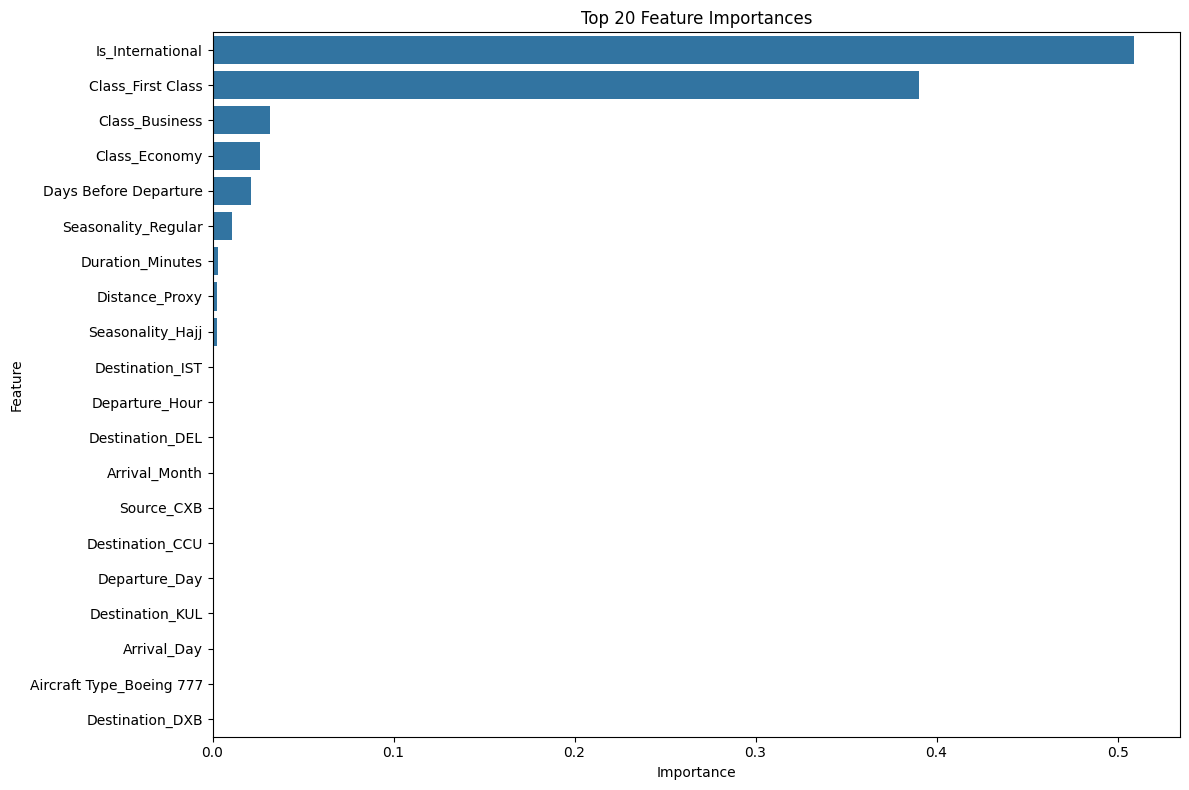

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters: {'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 100}
Best CV score: 0.6845


In [12]:
# Define models to try
models = {
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge(alpha=1.0),
    'Lasso': Lasso(alpha=1.0)
}

# Train and evaluate models
results = {}
for name, model in models.items():
    # Create pipeline
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    # Train the model
    pipeline.fit(X_train, y_train)

    # Make predictions
    y_pred = pipeline.predict(X_test)

    # Calculate metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    results[name] = {
        'MAE': mae,
        'RMSE': rmse,
        'R2': r2,
        'model': pipeline
    }

    print(f"{name}:")
    print(f"  MAE: {mae:.2f}")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  R2: {r2:.4f}")
    print()

# Find the best model
best_model_name = max(results.keys(), key=lambda x: results[x]['R2'])
best_model = results[best_model_name]['model']
print(f"Best model: {best_model_name}")

# Feature importance for tree-based models
if hasattr(best_model.named_steps['model'], 'feature_importances_'):
    # Get feature names after one-hot encoding
    preprocessor.fit(X_train)
    feature_names = numerical_cols + list(
        best_model.named_steps['preprocessor'].named_transformers_['cat']
        .named_steps['onehot'].get_feature_names_out(categorical_cols)
    )

    # Get feature importances
    importances = best_model.named_steps['model'].feature_importances_

    # Create feature importance dataframe
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values('Importance', ascending=False)

    # Plot top 20 features
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature',
                data=feature_importance_df.head(20))
    plt.title('Top 20 Feature Importances')
    plt.tight_layout()
    plt.show()

# Hyperparameter tuning for the best model
if best_model_name in ['Random Forest', 'Gradient Boosting']:
    param_grid = {}

    if best_model_name == 'Random Forest':
        param_grid = {
            'model__n_estimators': [100, 200],
            'model__max_depth': [None, 10, 20],
            'model__min_samples_split': [2, 5]
        }
    elif best_model_name == 'Gradient Boosting':
        param_grid = {
            'model__n_estimators': [100, 200],
            'model__learning_rate': [0.05, 0.1],
            'model__max_depth': [3, 5]
        }

    grid_search = GridSearchCV(
        best_model, param_grid, cv=5,
        scoring='r2', n_jobs=-1, verbose=1
    )

    grid_search.fit(X_train, y_train)

    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best CV score: {grid_search.best_score_:.4f}")

    # Update best model
    best_model = grid_search.best_estimator_



Final Model Performance:
MAE: 27981.27
RMSE: 46211.18
R2: 0.6797


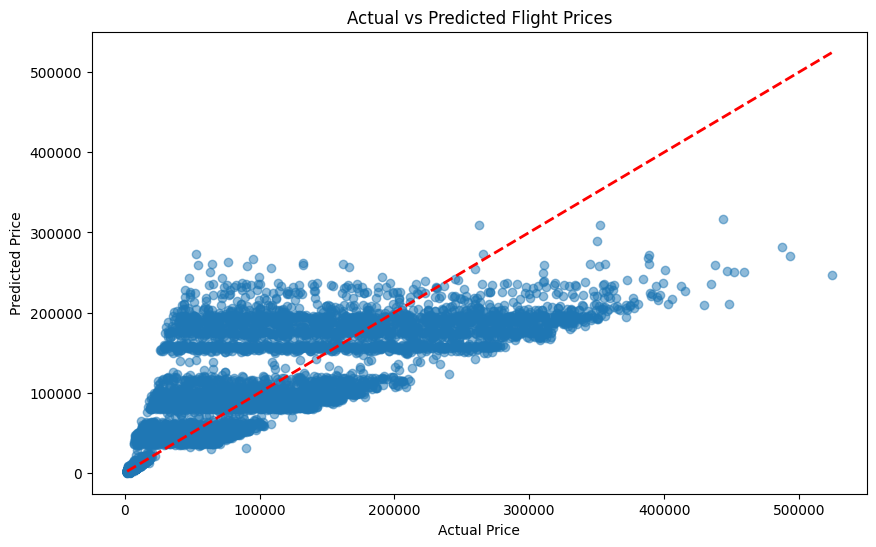

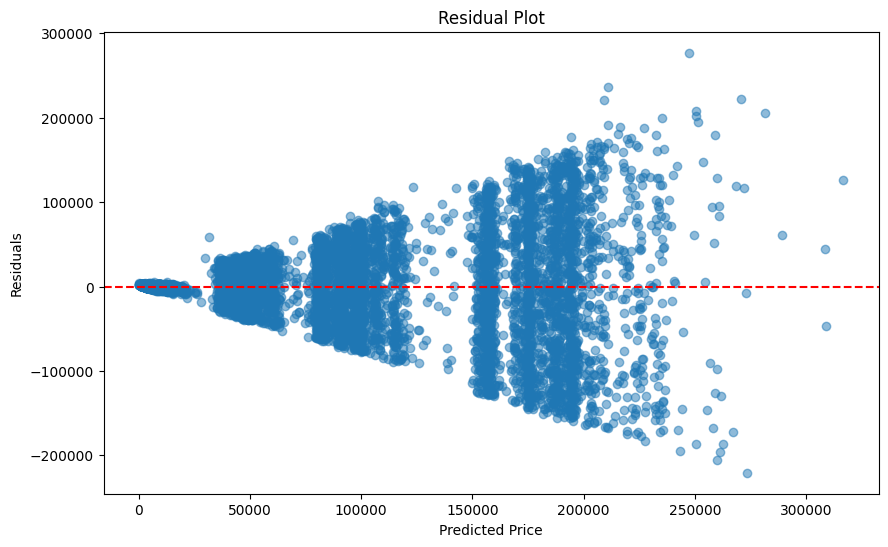

Model saved as flight_price_predictor.pkl


In [13]:
# Final evaluation on test set
y_pred_final = best_model.predict(X_test)

final_mae = mean_absolute_error(y_test, y_pred_final)
final_rmse = np.sqrt(mean_squared_error(y_test, y_pred_final))
final_r2 = r2_score(y_test, y_pred_final)

print("\nFinal Model Performance:")
print(f"MAE: {final_mae:.2f}")
print(f"RMSE: {final_rmse:.2f}")
print(f"R2: {final_r2:.4f}")

# Plot actual vs predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_final, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Flight Prices')
plt.show()

# Residual plot
residuals = y_test - y_pred_final
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_final, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Price')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

# Function to predict price for new data
def predict_flight_price(model, flight_data):
    """
    Predict flight price for new data
    flight_data should be a dictionary with the same structure as the training data
    """
    # Convert to DataFrame
    flight_df = pd.DataFrame([flight_data])

    # Preprocess the data (same as training)
    flight_processed = preprocess_data(flight_df)

    # Make prediction
    prediction = model.predict(flight_processed)

    return prediction[0]

# Example usage:
# sample_flight = {
#     'Airline': 'Malaysian Airlines',
#     'Source': 'CXB',
#     'Destination': 'CCU',
#     'Aircraft Type': 'Airbus A320',
#     'Class': 'Economy',
#     'Booking Source': 'Online Website',
#     'Seasonality': 'Regular',
#     'Days Before Departure': 10
# }
# predicted_price = predict_flight_price(best_model, sample_flight)
# print(f"Predicted price: {predicted_price:.2f} BDT")

# Save the model
import joblib
joblib.dump(best_model, 'flight_price_predictor.pkl')
print("Model saved as flight_price_predictor.pkl")

# Load the model (for future use)
# loaded_model = joblib.load('flight_price_predictor.pkl')

In [16]:
# Example: Predict price for a new flight
sample_flight = {
    'Airline': 'Malaysian Airlines',
    'Source': 'CXB',
    'Destination': 'Bali',
    'Aircraft Type': 'Airbus A320',
    'Class': 'Economy',
    'Booking Source': 'Online Website',
    'Seasonality': 'Regular',
    'Days Before Departure': 10,
    # The function will automatically handle datetime conversion
    'Departure Date & Time': '2025-11-17 06:25:00',
    'Arrival Date & Time': '2025-11-17 07:38:10',
    'Stopovers': 'Direct' # Added Stopovers key
}

predicted_price = predict_flight_price(best_model, sample_flight)
print(f"Predicted price: {predicted_price:.2f} BDT")

Predicted price: 4321.73 BDT
